<a href="https://colab.research.google.com/github/CaP4iK/cretes/blob/main/dl_nlp_ag_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Сначала
Используется три архитектуры нейронных сетей:
- Одномерная сверточная нейросеть
- Рекуррентная нейросеть LSTM
- Рекуррентная нейросеть GRU


Не забудь подключить GPU, чтобы сеть обучалась быстрее 

In [2]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина текста
max_news_len = 30
# Количество классов текста
nb_classes = 7

## Загрузка набора данных

Загружаем данные для обучения

In [4]:
!wget https://raw.githubusercontent.com/CaP4iK/cretes/main/dataset.csv -O dataset.csv

--2021-04-18 20:22:18--  https://raw.githubusercontent.com/CaP4iK/cretes/main/dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9952 (9.7K) [text/plain]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>]   9.72K  --.-KB/s    in 0s      

2021-04-18 20:22:18 (56.9 MB/s) - ‘dataset.csv’ saved [9952/9952]



Загружаем данные для тестирования

In [5]:
!wget https://raw.githubusercontent.com/CaP4iK/cretes/main/test.csv -O test.csv

--2021-04-18 20:22:22--  https://raw.githubusercontent.com/CaP4iK/cretes/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111 (2.1K) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>]   2.06K  --.-KB/s    in 0s      

2021-04-18 20:22:23 (28.8 MB/s) - ‘test.csv’ saved [2111/2111]



Загружаем имена классов

In [6]:
!wget https://raw.githubusercontent.com/CaP4iK/cretes/main/classes.txt -O classes.txt

--2021-04-18 20:22:25--  https://raw.githubusercontent.com/CaP4iK/cretes/main/classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255 [text/plain]
Saving to: ‘classes.txt’

classes.txt         100%[===================>]     255  --.-KB/s    in 0s      

2021-04-18 20:22:26 (12.6 MB/s) - ‘classes.txt’ saved [255/255]



## Просматриваем данные

In [7]:
!ls

best_model_cnn.h5   classes.txt  sample_data
best_model_lstm.h5  dataset.csv  test.csv


In [8]:
!cat classes.txt

﻿Дизайн
Нефункц. требования
Взаимодействие пользователя
Структура
Общие сведения документа
Функц. требования
дополнительные материалы.


In [10]:
!head dataset.csv

﻿"1","Дизайн страниц выполняется в строгом соответствии с корпоративным стилем компании, с пожеланиями клиента.Исполнитель предоставляет Заказчику вариант концепции дизайна на примере начальной страницы. После утверждения Исполнитель приступает к выполнению оставшихся страниц."
"1","Стиль оформления произвольный. Количество знаков заголовка и анонса не лимитировано. Заголовок новости является ссылкой. При нажатии на ссылку"
"1","Графическая шапка с горизонтальной навигацией может содержать ненавязчивые флэш-элементы (например, анимированный логотип, являющийся одновременно ссылкой на основную страницу сайта), но не должна отвлекать от информационного наполнения страницы. Желательна разработка нескольких вариантов графической шапки в привязке к основным разделам каталога. Для разделов основной навигации разрабатывается общая шапка."
"1","Внутренняя навигация раздела «Каталог» отображается в виде списка в левой части экрана под шапкой в виде колонки в текстовом виде для последующей легко

In [11]:
!head test.csv

﻿"1","Дизайн страниц выполняется в строгом соответствии с корпоративным стилем компании и с пожеланиями клиента."
"2","Сайт разрабатывается под базовое разрешение экрана 800х600 пкс"
"3","По ссылке на заголовок тура пользователь переходит на страницу с полным описанием конкретного тура." 
"4"," «О компании» - содержит краткую информацию раздела со ссылкой «подробнее», ведущую на раздел «О компании»."
"1","Среди используемых цветов должен быть белый"
"4","«Личный кабинет» - должен содержать информацию о пользователе"
"2","В случае невозможности завершения рассылки, система предпринимает повторные попытку рассылки."
"3","Для восстановления забытого пароля, пользователь нажимает кнопку «забыли пароль»"
"2","Система осуществляет рассылку оповещений по адресам из списка рассылки X, используя шаблон Y. Для рассылки сообщений используется сервис Z."
"6","Модуль встреч должен планировать, переносить и удалять встречи."


In [13]:
!wc -l dataset.csv
!wc -l test.csv

27 dataset.csv
15 test.csv


## Загружаем данные в память

Читаем данные из файла

In [14]:
dataset = pd.read_csv('dataset.csv', 
                    header=None, 
                    names=['class','text'])

In [15]:
dataset

,class,text
0,1,Дизайн страниц выполняется в строгом соответст...
1,1,Стиль оформления произвольный. Количество знак...
2,1,Графическая шапка с горизонтальной навигацией ...
3,1,Внутренняя навигация раздела «Каталог» отображ...
4,1,В дизайне отдельно предусматриваются ссылки на...
5,1,Между шапкой и контентной областью предполагае...
6,1,Внизу страницы отображается облегченная навига...
7,2,Сайт разрабатывается под базовое разрешение эк...
8,3,По ссылке на заголовок тура пользователь перех...
9,2,Корректное отображение браузерами Internet Exp...


Выделяем данные для обучения

In [16]:
tz = dataset['text']

In [17]:
tz[:5]

0    Дизайн страниц выполняется в строгом соответст...
1    Стиль оформления произвольный. Количество знак...
2    Графическая шапка с горизонтальной навигацией ...
3    Внутренняя навигация раздела «Каталог» отображ...
4    В дизайне отдельно предусматриваются ссылки на...
Name: text, dtype: object

Выделяем правильные ответы

In [18]:
y_tz = utils.to_categorical(dataset['class']-1, nb_classes)

In [19]:
y_tz

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

## Токенизация текста

In [20]:
tz[:5]

0    Дизайн страниц выполняется в строгом соответст...
1    Стиль оформления произвольный. Количество знак...
2    Графическая шапка с горизонтальной навигацией ...
3    Внутренняя навигация раздела «Каталог» отображ...
4    В дизайне отдельно предусматриваются ссылки на...
Name: text, dtype: object

Создаем токенизатор Keras

In [21]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на IT Записях

In [22]:
tokenizer.fit_on_texts(tz)

Просматриваем словарь токенизатора

In [23]:
tokenizer.word_index

{'0': 222,
 '800х600': 184,
 'aport': 265,
 'arial': 85,
 'copyright': 177,
 'courier': 382,
 'e': 30,
 'explorer': 217,
 'futura': 367,
 'helvetica': 378,
 'internet': 216,
 'mail': 17,
 'navigator': 219,
 'netscape': 218,
 'new': 380,
 'rambler': 266,
 'roman': 381,
 'times': 379,
 'yandex': 264,
 '«баннерная': 172,
 '«вернуться': 293,
 '«визуалов»': 354,
 '«дорого»': 349,
 '«заказать': 193,
 '«интерактив»': 233,
 '«каталог»': 154,
 '«корзины»': 298,
 '«о': 72,
 '«основную': 180,
 '«отправить': 74,
 '«подробнее»': 283,
 '«подтвердить': 36,
 'а': 68,
 'автоматически': 205,
 'авторизовался': 335,
 'администратор': 406,
 'администратора': 300,
 'активных': 235,
 'анимированный': 131,
 'анонса': 118,
 'б': 255,
 'базовое': 182,
 'без': 324,
 'бланк': 245,
 'браузерами': 215,
 'браузеров': 377,
 'бы': 421,
 'быть': 22,
 'в': 2,
 'вариант': 103,
 'вариантов': 141,
 'вверху': 192,
 'вводную': 276,
 'ведущую': 284,
 'версии': 220,
 'версия': 418,
 'взаимодействие': 337,
 'виде': 16,
 'видеть

Преобразуем текст в числовое представление

In [24]:
sequences = tokenizer.texts_to_sequences(tz)

Просматриваем новости в числовом представлении

In [25]:
index = 1
print(tz[index])
print(sequences[index])

Стиль оформления произвольный. Количество знаков заголовка и анонса не лимитировано. Заголовок новости является ссылкой. При нажатии на ссылку
[113, 15, 114, 115, 116, 117, 3, 118, 10, 119, 41, 120, 121, 26, 42, 122, 1, 123]


In [26]:
tokenizer.word_index['логотип']

132

Ограничиваем длину текста

In [27]:
x_tz = pad_sequences(sequences, maxlen=max_news_len)

In [28]:
x_tz[:5]

array([[ 39,  94,   2,  95,  96,   5,  97,  98,   7,   5,  99, 100,  40,
        101, 102, 103, 104, 105,   1, 106, 107,   9, 108, 109,  40, 110,
         11, 111, 112,  39],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 113,
         15, 114, 115, 116, 117,   3, 118,  10, 119,  41, 120, 121,  26,
         42, 122,   1, 123],
       [ 45,  12,   4,  46,  10,  47, 135, 136, 137, 138,   9, 139, 140,
         48, 141, 142, 143,   2, 144,  11, 145, 146, 147,   6, 148, 149,
        150,  49, 151,  43],
       [  0,   0,   0,   0, 152, 153,  50, 154,  51,   2,  16, 155,   2,
        156, 157,  28,  29,  52,   2,  16, 158,   2,  53,  16,   6, 159,
        160, 161, 162, 163],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   2,  54, 164,  55,  56,   1,
        165, 166,   3, 167]], dtype=int32)

## Сверточная нейронная сеть

In [33]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(7, activation='softmax'))

In [34]:
model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [35]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 32)            320000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 26, 250)           40250     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 250)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32128     
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 903       
Total params: 393,281
Trainable params: 393,281
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [40]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [41]:
history_cnn = model_cnn.fit(x_tz, 
                            y_tz, 
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/50
1/1 [==============================] - 0s 109ms/step - loss: 1.7637 - accuracy: 0.3913 - val_loss: 2.1677 - val_accuracy: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to best_model_cnn.h5
Epoch 2/50
1/1 [==============================] - 0s 54ms/step - loss: 1.7277 - accuracy: 0.3913 - val_loss: 2.2132 - val_accuracy: 0.0000e+00

Epoch 00002: val_accuracy did not improve from 0.00000
Epoch 3/50
1/1 [==============================] - 0s 58ms/step - loss: 1.6906 - accuracy: 0.3913 - val_loss: 2.2628 - val_accuracy: 0.0000e+00

Epoch 00003: val_accuracy did not improve from 0.00000
Epoch 4/50
1/1 [==============================] - 0s 59ms/step - loss: 1.6525 - accuracy: 0.3913 - val_loss: 2.3170 - val_accuracy: 0.0000e+00

Epoch 00004: val_accuracy did not improve from 0.00000
Epoch 5/50
1/1 [==============================] - 0s 54ms/step - loss: 1.6129 - accuracy: 0.3913 - val_loss: 2.3760 - val_accuracy: 0.0000e+00

Epoch 00005: val_accura

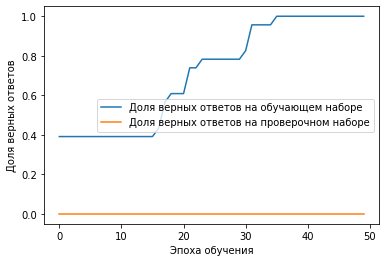

In [42]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть LSTM

In [43]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(7, activation='softmax'))

In [44]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [45]:
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 32)            320000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 119       
Total params: 323,255
Trainable params: 323,255
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [46]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [47]:
history_lstm = model_lstm.fit(x_tz, 
                              y_tz, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 1.9465 - accuracy: 0.1739 - val_loss: 1.9562 - val_accuracy: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to best_model_lstm.h5
Epoch 2/5
1/1 [==============================] - 0s 59ms/step - loss: 1.9405 - accuracy: 0.1304 - val_loss: 1.9598 - val_accuracy: 0.0000e+00

Epoch 00002: val_accuracy did not improve from 0.00000
Epoch 3/5
1/1 [==============================] - 0s 77ms/step - loss: 1.9344 - accuracy: 0.5217 - val_loss: 1.9634 - val_accuracy: 0.0000e+00

Epoch 00003: val_accuracy did not improve from 0.00000
Epoch 4/5
1/1 [==============================] - 0s 74ms/step - loss: 1.9283 - accuracy: 0.6957 - val_loss: 1.9671 - val_accuracy: 0.0000e+00

Epoch 00004: val_accuracy did not improve from 0.00000
Epoch 5/5
1/1 [==============================] - 0s 68ms/step - loss: 1.9222 - accuracy: 0.7391 - val_loss: 1.9708 - val_accuracy: 0.0000e+00

Epoch 00005: val_accuracy did 

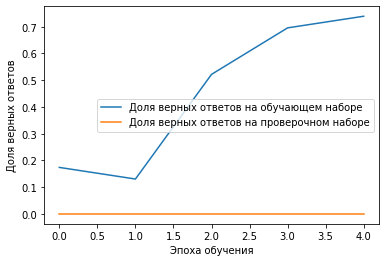

In [48]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть GRU

In [51]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(16))
model_gru.add(Dense(7, activation='softmax'))

In [52]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [53]:
model_gru.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 32)            320000    
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 119       
Total params: 322,519
Trainable params: 322,519
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model_gru.h5`

In [54]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [55]:
history_gru = model_gru.fit(x_tz, 
                              y_tz, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 1.9353 - accuracy: 0.5217 - val_loss: 1.9531 - val_accuracy: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to best_model_gru.h5
Epoch 2/5
1/1 [==============================] - 0s 70ms/step - loss: 1.9269 - accuracy: 0.6087 - val_loss: 1.9576 - val_accuracy: 0.0000e+00

Epoch 00002: val_accuracy did not improve from 0.00000
Epoch 3/5
1/1 [==============================] - 0s 77ms/step - loss: 1.9183 - accuracy: 0.6957 - val_loss: 1.9622 - val_accuracy: 0.0000e+00

Epoch 00003: val_accuracy did not improve from 0.00000
Epoch 4/5
1/1 [==============================] - 0s 80ms/step - loss: 1.9097 - accuracy: 0.6957 - val_loss: 1.9669 - val_accuracy: 0.0000e+00

Epoch 00004: val_accuracy did not improve from 0.00000
Epoch 5/5
1/1 [==============================] - 0s 67ms/step - loss: 1.9010 - accuracy: 0.6087 - val_loss: 1.9717 - val_accuracy: 0.0000e+00

Epoch 00005: val_accuracy did n

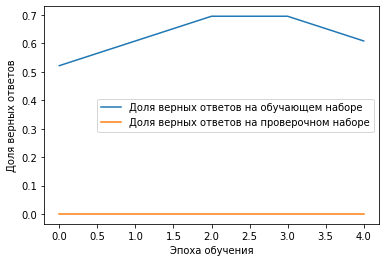

In [56]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Загружаем набор данных для тестирования

In [57]:
test = pd.read_csv('test.csv', 
                    header=None, 
                    names=['class', 'text'])

In [58]:
test

,class,text
0,1,Дизайн страниц выполняется в строгом соответст...
1,2,Сайт разрабатывается под базовое разрешение эк...
2,3,По ссылке на заголовок тура пользователь перех...
3,4,«О компании» - содержит краткую информацию ра...
4,1,Среди используемых цветов должен быть белый
5,4,«Личный кабинет» - должен содержать информацию...
6,2,"В случае невозможности завершения рассылки, си..."
7,3,"Для восстановления забытого пароля, пользовате..."
8,2,Система осуществляет рассылку оповещений по ад...
9,6,"Модуль встреч должен планировать, переносить и..."


Преобразуем новости в числовое представление

Обратите внимание, что нужно использовать токенизатор, обученный на наборе данных train.

In [59]:
test_sequences = tokenizer.texts_to_sequences(test['text'])

In [60]:
x_test = pad_sequences(test_sequences, maxlen=max_news_len)

In [61]:
x_test[:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  25,  39,  94,   2,  95,  96,   5,  97,  98,   7,
          3,   5,  99, 100],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,  58,  49,  29, 182,
        183,  28, 184, 185],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   8,  31,   1,  41,  32,  13,  33,   1,  12,   5,
        186, 187, 188,  32],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  72,  73,  67, 281,  71,  50, 282,  26, 283, 284,
          1, 285,  72,  73],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 225,  23,  22]], dtype=int32)

Правильные ответы

In [62]:
y_test = utils.to_categorical(test['class'] - 1 , nb_classes)

In [63]:
y_test

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

## Оцениваем качество работы сети на тестовом наборе данных

### Одномерная сверточная сеть 

In [64]:
model_cnn.load_weights(model_cnn_save_path)

In [65]:
model_cnn.evaluate(x_test, y_test, verbose=1)

1/1 [==============================] - 0s 18ms/step - loss: 1.9089 - accuracy: 0.1538


[1.908919095993042, 0.1538461595773697]

### Сеть LSTM

In [70]:
model_lstm.load_weights(model_lstm_save_path)

In [71]:
model_lstm.evaluate(x_test, y_test, verbose=1)

1/1 [==============================] - 0s 17ms/step - loss: 1.9451 - accuracy: 0.0000e+00


[1.9451229572296143, 0.0]

### Сеть GRU

In [68]:
model_gru.load_weights(model_gru_save_path)

In [72]:
model_gru.evaluate(x_test, y_test, verbose=1)

1/1 [==============================] - 0s 16ms/step - loss: 1.9477 - accuracy: 0.2308


[1.9476839303970337, 0.23076923191547394]

## Полезные ссылки

1. [Определение тональности текстов отзывов на сайте YELP одномерной сверточной нейросетью](https://colab.research.google.com/drive/1KWS-4MKKOIG7UhiCA58ZJcxwSLG5F6Wm).
2. [Определение тональности текстов отзывов на сайте YELP сетью LSTM](https://colab.research.google.com/drive/19olgYyZ4N5fh8RIPtHxkso2N5HD1yg0X).
3. [Использование командной строки Linux в Colab](https://colab.research.google.com/drive/1vFGZ2nDS0ukNGXPL-0avK097afYQILyq).